# Pitch prediction -- regression

If a batter knows what pitch is coming, he is more likely to be able to hit it or lay off of it. Therefore, if a pitcher's next pitch can be predicted, a massive advantage goes to the batter. I will look into the possibility of pitch prediction in the following notebook.

I will start with importing some standard libraries.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Approach

I will look to predict pitches by using as few features as possible. Thus, I will begin by selecting raw features in the database based on human intuition. I intend to only turn to feature engineering if results are poor.

I intend to predict pitches using random forest. This approach has the advantages that it can display both low bias and low variance if results from a large number of decision trees are averaged. Additionally, random forest has a track record of good performance, can handle both regression and classification problems, and can also rank features based on influence on the response. Some drawbacks are that this approach can take up a lot of memory if the size of the dataset and the number of trees is large, and the forests themselves are a bit of a black box in terms of interpretability. Additionally, each pitcher is treated individually since each pitcher will have different pitch tendencies.

For the particular problem of pitch prediction, there are two possible responses that could be used: a categorical response that describes the pitch type (e.g., four-seam fastball, curveball, slider, etc.), or a numerical response that describes the trajectory of the ball (e.g., velocity and vertical/horizontal acceleration).

Ideally, there would be reliable pitch-type labels so that noise in the response that's being predicted would be limited. For example, noise from slightly different trajectories of the same pitch would be limited by classifying them as the same pitch. Additionally, this approach would have a simple baseline metric from which to test my model against: does the model perform better than guessing the most commonly thrown pitch type every pitch? However, from previous work with pitch classification, I concluded that all pitch-type labels should be taken with caution. For instance, the difference between a two-seam and a four-seam fastball can be subjective, and the number of pitches in a pitcher's repertoire is also subjective. One option is to group all pitches into two labels: fastball and off-speed. While this approach would limit the number of misclassified pitches, it also fails to fully exploit the wealth of pitch trajectory information in the database.

Alternatively, I could fully utilize the information in the database and try to predict the trajectory of the next pitch. From my pitch classification work, it appeared that velocity and acceleration were the most important features for separating pitch type, making them candidates for prediction. The advantage here is that the labels are more reliable than an arbitrary pitch type label; it is the raw data. This approach, however, would be sensitive to noise in the data. Again, a given pitch type is not executed perfectly every time, resulting in a range of trajectories. I am not interested so much in fitting the exact pitch trajectory of the next pitch as I am in estimating an approximate pitch trajectory that allows the hitter to distinguish between pitch types. Additionally, this approach has the additional challenge that it is difficult to specify a baseline metric to test my model against. Would I just guess the average trajectory of all pitch types every pitch?

Here, I will pursue the latter approach because the labels are more reliable. To combat overfitting, I'll look to average over a large number of decision trees, as the variance of the method decreases as the number of trees used increases. For a baseline metric, I will use the root-mean-squared error of all observations with respect to the mean value (for velocity and acceleration).

## Loading data

Pitch prediction will not only depend on the previous pitch thrown, but also variables such as game situation. Therefore, I will load the *pitchfx*, *events*, and *games* tables in the database as pandas dataframes so that I maintain maximum flexibility. I will focus on Barry Zito again for this study.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

In [3]:
# import classes
sys.path.append('../src')
from Player import Player

# create player object
bz = Player("Barry Zito", db)

# grab pitches
bz_pitches = bz.pitches(clean=1)
# grab events
bz_events = bz.pitch_events()
# grab games
bz_games = bz.pitch_games()

## Data preprocessing

Feature selection can sometimes be more art than science. Here, I will prepare a subset of features that intuition suggests will help predict the type of pitch thrown. They are, loosely, the current ball-strike count, the handedness of the batter, and the baserunner situation. I will prepare these features one by one.

### Ball-strike count

Pitchers will likely pitch differently depending on the ball-strike count. For instance, if the count is 0-2 (0 balls, 2 strikes), a pitcher can throw any pitch because he knows he has 3 more tries to get the batter out. On the other hand, if the count is 3-0 (3 balls, 0 strikes), a pitcher will likely throw a pitch he trusts most in terms of command (often a fastball) because the pitcher will oftentimes want to avoid walking the batter.

In terms of how to represent the count as a feature, there are a couple of options: treat the number of balls and the number of strikes independently, or treat each count as its own category. For now, I will treat the number of balls and strikes as independent features because it requires less feature manipulation. Furthermore, I will keep their original values (0-3 for balls, 0-2 for strikes) rather than encode them, as the order of these numbers has meaning.

In [4]:
# create first feature
features = bz_pitches[["pre_balls", "pre_strike"]].reset_index(drop=True)

# print length of vector
print("number of data points: ", features.shape[0])

number of data points:  3079


### Handedness of batter

The next pitch is also likely influenced by the handedness of the batter. For example, certain pitches are more effective when the pitcher handedness and batter handedness match (such as a breaking ball), and are thus more likely to be thrown.

To get the handedness of the batter for each pitch, I'll need to join the *pitchfx* table with both the *events* table (to tie the pitch to a batter id) and the *players* table (to tie the batter id to the batter handedness). I will do this all in pandas, which requires me to import the *players* table as a pandas dataframe.

In [5]:
# save players table as pandas data frame
query = """SELECT *
        FROM players
        """
players = pd.read_sql_query(query, db)

I'll perform a sequence of left joins. I'll join the *events* table first to the pitches in order to get the batter information. I will then join that resulting table to the *players* table in order to get the batter handedness. Note that I will only add the columns I need (*player_id* and *bats*) and will need to drop the duplicate player information before joining the tables since the same player will have multiple entries if he plays multiple positions.

In [6]:
# merge tables to get the batter handedness for each pitch
handedness = bz_pitches.merge(bz_events[['game_id', 'event_id', 'batter_id']],
                              left_on=['game_id', 'cur_event'],
                              right_on=['game_id', 'event_id'],
                              how='left') \
                       .merge(players[['player_id', 'bats']].drop_duplicates(),
                              left_on='batter_id',
                              right_on='player_id',
                              how='left') \
                       .sort_values(by=['game_id', 'cur_event'])['bats']
        
# print length of vector
print("number of data points: ", handedness.shape[0])

number of data points:  3079


There are three different batter handednesses: left, right, and switch. Typically, switch hitters bat with the opposite hand of the pitcher. Therefore, because Zito throws with his left hand, I will change all switch hitters to bat right-handed here.

#### Aside: encoding categorical features

*sklearn* assumes all inputs are numerical and continuous. Therefore, I need to choose a method to convert categorical variables to numerical variables. In general, there are a number of possible approaches, including:

1) numerical encoding (each category is associated with an integer). Pros: simple to implement. Cons: assumes that integers are ordered, and therefore that categories are somehow ordered (which is not always the case).

2) one-hot encoding (each category is effectively a vector of length (number of categories) with zeros everywhere but one entry corresponding to the category). Pros: many methods in *sklearn* and *pandas* can implement this; effectively turns each category into an almost-binary value; shown to have better performance than numerical encoding. Cons: can increase feature space significantly if variable has a lot of categories; with decision trees, resulting sparsity virtually ensures that continuous variables are assigned higher feature importance; features with more categories are favored.

3) binary encoding (take numerical encoding and express values in binary). Pros: fewer added features than one-hot encoding; good performance like one-hot encoding. Cons: less straight forward to implement.

Since handedness is binary (left or right), I convert the strings into 0 (left) and 1 (right). In some ways this is like one-hot or binary encoding, but requiring only (number of categories)-1 features since if one value is known the other can be inferred.

In [7]:
# print unique entries of batter handedness
print("unique batter handednesses: ", players['bats'].unique())

# update switch hitters in batter handedness based on pitcher's throwing hand
pthrows = bz.info()['throws'].unique()[0]
if pthrows=='L':
    handedness[handedness=='S'] = 'R'
else:
    handedness[handedness=='S'] = 'L'
print("new unique batter handednesses: ", handedness.unique())

# convert to binary
handedness[handedness=='L'] = 0
handedness[handedness=='R'] = 1

unique batter handednesses:  ['L' 'R' 'S']
new unique batter handednesses:  ['R' 'L']


In [8]:
# add handedness of batter to features (0: left, 1: right)
features['bats'] = handedness

### Baserunner situation

Having baserunners on base can influence the type of pitch thrown. For instance, if there is a runner on first, a pitcher might be more inclined to throw a pitch with downward movement to induce a grounder for a double play.

To represent the baserunning situation, there are a few options. One is to treat each base independently (in other words, have one feature for each base (first, second, third) that is 1 when there is a runner and 0 when there is no runner). Another is to treat each baserunner combination as its own category. Another is to create a feature there higher values indicate more runners on base closer to home (in other words, sum the runners on base where first has weight 1, second has weight 2, and third has weight 4). I will initially list each base independently, tying the *event* table to each pitch.

In [9]:
# get baserunners for each pitch
runners = bz_pitches.merge(bz_events,
                           left_on=['game_id', 'cur_event'],
                           right_on=['game_id', 'event_id'],
                           how='left')[['pre_1b', 'pre_2b', 'pre_3b']]

# convert runners to binary
runners[runners>0] = 1

In [10]:
# append runners to dataframe
features = pd.concat([features, runners], axis=1)

### Pitch trajectory responses

I will try to predict starting velocity, horizontal acceleration, and vertical acceleration. These values are already in the *pitchfx* database.

In [11]:
# create response variable
response = bz_pitches[["start_speed", "ax", "az"]].reset_index(drop=True)

## Random forest with basic features

Random forest is a popular ensemble method that averages the results from a number of decision trees grown from bootstrapped data. Here, I will use a random forest regression (rather than classifier) because I want to fit continuous values of velocity and accelerations.

### Training and test data split

The first step is to divide the dataset into a training set and a test set. Here, I will start by taking randomly taking 80% of the data to be the training set and the remaining 20% of the data to be the test set. For validating my model, I will look to examine the out-of-bag error, which corresponds to the data points not used when bootstrapping in random forest.

In [12]:
def split_data(X, y, percent_train, random_seed):
    """Split data into training and test sets
    
    Inputs:
        X: features numpy or pandas array (n_observations, n_features)
        y: response numpy or pandas array (n_observations, n_responses)
        percent_train: percent of observations taken to be the training set
        random_seed: seed for random selection of training observations
        
    Outputs:
        X_train: training features numpy or pandas array (percent_train*n_observations, n_features)
        X_test: test features numpy or pandas array ((1-percent_train*n_observations), n_features)
        y_train: training response or pandas numpy array (percent_train*n_observations, n_responses)
        y_test: test features numpy or pandas array ((1-percent_train*n_observations), n_responses)
        
    Notes:
        - data type in is the same as data type out
    """
    # check that X and y are same lengths
    if X.shape[0]!=y.shape[0]:
        print("Lengths of features and responses do no match")
        return
    
    # set parameters
    np.random.seed(random_seed)
    ndata = X.shape[0]
    rand_indices = np.random.choice([True, False], size=ndata, p=[percent_train, 1-percent_train])
    
    # get data
    try:
        X_train = X[rand_indices, :]
        X_test = X[~rand_indices, :]
        y_train = y[rand_indices, :]
        y_test = y[~rand_indices, :]
    except:
        X_train = X.iloc[rand_indices, :]
        X_test = X.iloc[~rand_indices, :]
        y_train = y.iloc[rand_indices, :]
        y_test = y.iloc[~rand_indices, :]
    
    # clean up
    return X_train, X_test, y_train, y_test

In [13]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = split_data(features, response, 0.7, 0)

### Random forest multi-label output approach

There are two general approaches to the multi-label regression output. One is to assume that all three categories to be predicted are independent of each other. In other words, the features being predicted are uncorrelated with each other. Another approach is to assume that the categories are correlated with each other.

#### Independent responses

I will focus on the former assumption for now, as that is what *sklearn*'s multi-label random forest regressor implements. 

In [14]:
# imports
from sklearn.ensemble import RandomForestRegressor

# initialize random forest regressor
rf1 = RandomForestRegressor(n_estimators=500,
                            criterion='mse',
                            max_features='sqrt',
                            oob_score=True,
                            random_state=0).fit(X_train, y_train)
y_pred1 = rf1.predict(X_test)

Now I can compute the RMSE for each of the features being predicted.

In [15]:
# calculate rmse
def rmse(y, y_pred):
    """Calculate root-mean-square error
    
    Inputs:
        y: actual values
        y_pred: predicted values (if 1d, then assumed to be constants for each column)
        
    Outputs:
        rmse: root-mean-squared error
    """
    # calculate rmse
    rmse = np.sqrt( np.mean( (y-y_pred)**2))
    
    # clean up
    return rmse

In [16]:
# oob error (like validation set error)
print("oob errors: \n", rmse(y_train, rf1.oob_prediction_))
print("\n")
# test error
print("test errors: \n", rmse(y_test, y_pred1))

oob errors: 
 start_speed     5.883723
ax              6.299684
az             10.006826
dtype: float64


test errors: 
 start_speed     6.011512
ax              6.368291
az             10.222351
dtype: float64


To provide context for these values, I'll calculate a baseline error from the mean of the training examples.

In [17]:
# means from training data
y_means = np.mean(y_train)
    
# baseline error
print("baseline training errors: \n", rmse(y_train, y_means))
print("\n")
print("baseline test errors: \n", rmse(y_test, y_means))

baseline training errors: 
 start_speed     5.955868
ax              6.488037
az             10.192037
dtype: float64


baseline test errors: 
 start_speed     6.121702
ax              6.586006
az             10.504501
dtype: float64


Therefore, the model is leading to less error than when guessing the mean value for each feature. However, it is difficult to get a sense if the model performing well just by chance. Therefore, I'll look at histograms of the residuals for both the training and the test sets.

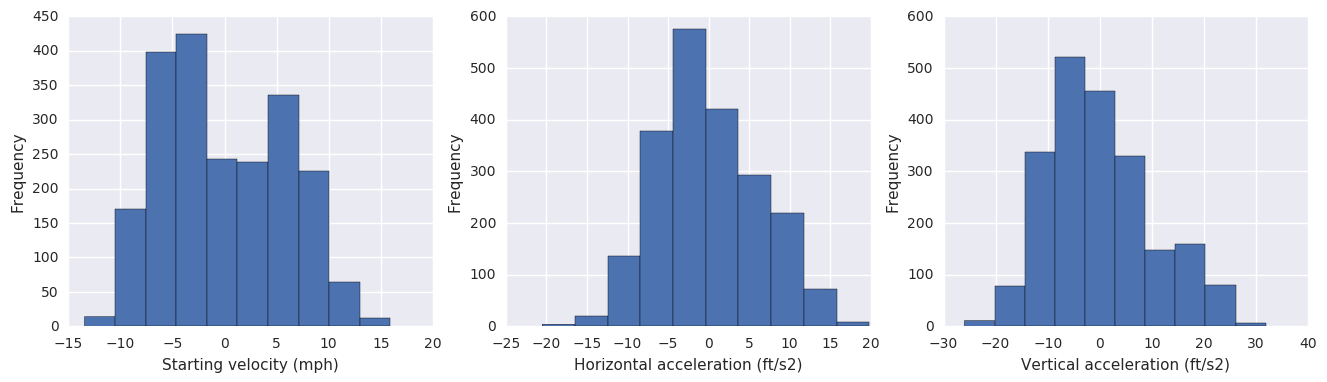

In [18]:
# histograms
diff_train = rf1.oob_prediction_-y_train
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
nbins = 10

diff_train['start_speed'].plot.hist(bins=nbins, ax=ax[0])
ax[0].set_xlabel("Starting velocity (mph)")

diff_train['ax'].plot.hist(bins=nbins, ax=ax[1])
ax[1].set_xlabel("Horizontal acceleration (ft/s2)")

diff_train['az'].plot.hist(bins=nbins, ax=ax[2])
ax[2].set_xlabel("Vertical acceleration (ft/s2)")

plt.show()

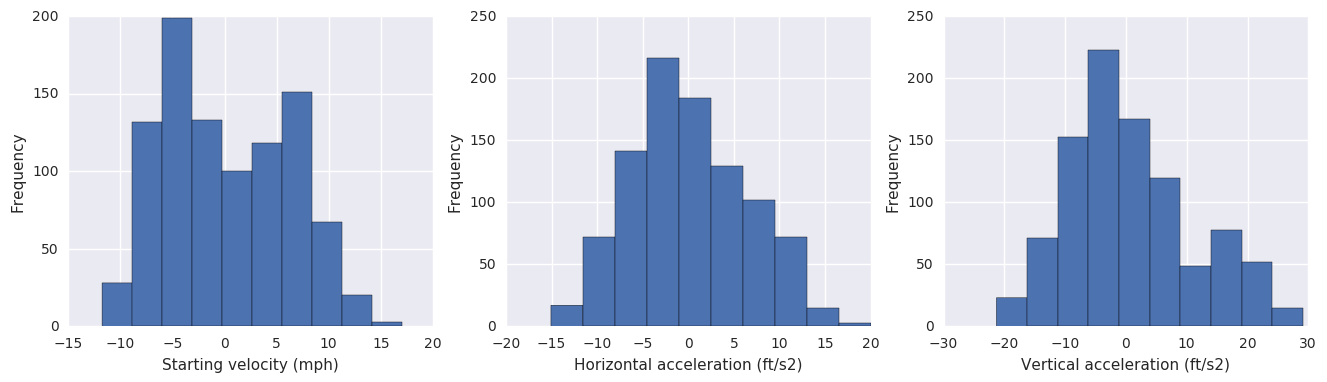

In [19]:
# histograms
diff_test = y_pred1-y_test
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
nbins = 10

diff_test['start_speed'].plot.hist(bins=nbins, ax=ax[0])
ax[0].set_xlabel("Starting velocity (mph)")

diff_test['ax'].plot.hist(bins=nbins, ax=ax[1])
ax[1].set_xlabel("Horizontal acceleration (ft/s2)")

diff_test['az'].plot.hist(bins=nbins, ax=ax[2])
ax[2].set_xlabel("Vertical acceleration (ft/s2)")

plt.show()

From these histograms of the residuals, it seems that none of the features are a centered at zero residual. This suggests that the model is generally underpredicting the velocity and accelerations.

### Adding more features

Begin by adding more information about the game situation, including the innning, numer of outs, whether pitching at home or away, and score differential at the time of the pitch.

In [20]:
# copy new features
features2 = features.copy()

# get game event info
extras = bz_pitches.merge(bz_events,
                          left_on=['game_id', 'cur_event'],
                          right_on=['game_id', 'event_id'],
                          how='left')

# innings
features2['inning'] = extras['inning']

# number of outs
features2['outs'] = extras['pre_out']

# score differential
score_diff = extras['pre_away_score']-extras['pre_home_score']
score_diff[extras['is_top_inning']==True] = -score_diff[extras['is_top_inning']==True]
features2['score_diff'] = score_diff
features2['home'] = extras['is_top_inning']

In [21]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = split_data(features2, response, 0.7, 0)

In [22]:
# initialize random forest regressor
rf2 = RandomForestRegressor(n_estimators=500,
                            criterion='mse',
                            max_features='sqrt',
                            oob_score=True,
                            random_state=0).fit(X_train, y_train)
y_pred2 = rf2.predict(X_test)

In [23]:
# oob error (like validation set error)
print("oob errors: \n", rmse(y_train, rf2.oob_prediction_))
print("\n")
# test error
print("test errors: \n", rmse(y_test, y_pred2))

oob errors: 
 start_speed     6.011143
ax              6.135508
az             10.353478
dtype: float64


test errors: 
 start_speed     6.217851
ax              6.139472
az             10.545253
dtype: float64


Results do no improve much.

Next, I'll add more information about the trajectories and locations of the previous three pitches. For the first and second pitches, the previous pitches will be filled with the information from the current pitch. This effects only two pitches out of the entire training set.

In [121]:
# copy
features3 = features2.copy()

# add previous pitches information
prev = bz_pitches[['start_speed', 'ax', 'az', 'px', 'pz']].reset_index(drop=True).shift(1)
prev.fillna(method='backfill', inplace=True)
prev2 = bz_pitches[['start_speed', 'ax', 'az', 'px', 'pz']].reset_index(drop=True).shift(2)
prev2.fillna(method='backfill', inplace=True)
prev3 = bz_pitches[['start_speed', 'ax', 'az', 'px', 'pz']].reset_index(drop=True).shift(3)
prev3.fillna(method='backfill', inplace=True)

In [122]:
# add to features
features3['prev_start_speed'] = prev['start_speed']
features3['prev_ax'] = prev['ax']
features3['prev_az'] = prev['az']
features3['prev_px'] = prev['px']
features3['prev_pz'] = prev['pz']
features3['prev2_start_speed'] = prev2['start_speed']
features3['prev2_ax'] = prev2['ax']
features3['prev2_az'] = prev2['az']
features3['prev2_px'] = prev2['px']
features3['prev2_pz'] = prev2['pz']
features3['prev3_start_speed'] = prev3['start_speed']
features3['prev3_ax'] = prev3['ax']
features3['prev3_az'] = prev3['az']
features3['prev3_px'] = prev3['px']
features3['prev3_pz'] = prev3['pz']

In [123]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = split_data(features3, response, 0.7, 0)

In [124]:
# initialize random forest regressor
rf3 = RandomForestRegressor(n_estimators=500,
                            criterion='mse',
                            max_features='sqrt',
                            oob_score=True,
                            random_state=0).fit(X_train, y_train)
y_pred3 = rf3.predict(X_test)

In [125]:
# oob error (like validation set error)
print("oob errors: \n", rmse(y_train, rf3.oob_prediction_))
print("\n")
# test error
print("test errors: \n", rmse(y_test, y_pred3))

oob errors: 
 start_speed    5.812228
ax             5.728858
az             9.787565
dtype: float64


test errors: 
 start_speed    5.918277
ax             5.746702
az             9.963009
dtype: float64


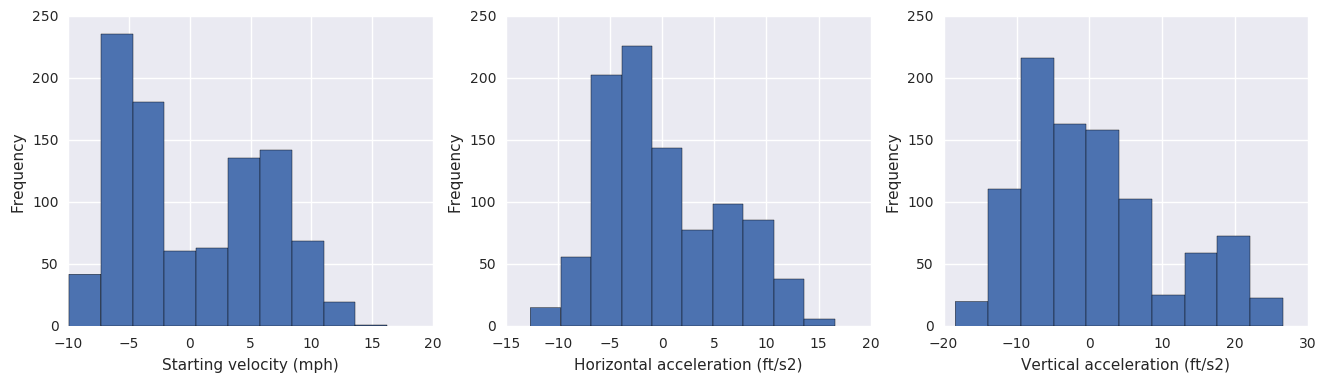

In [126]:
# histograms
diff_test = y_pred3-y_test
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
nbins = 10

diff_test['start_speed'].plot.hist(bins=nbins, ax=ax[0])
ax[0].set_xlabel("Starting velocity (mph)")

diff_test['ax'].plot.hist(bins=nbins, ax=ax[1])
ax[1].set_xlabel("Horizontal acceleration (ft/s2)")

diff_test['az'].plot.hist(bins=nbins, ax=ax[2])
ax[2].set_xlabel("Vertical acceleration (ft/s2)")

plt.show()

Results look a little better, as the RMSE has decreased a tiny bit.

Next I'll add information about the outcome of the previous pitch in terms of the description of the event. These descriptions are strings and will thus need to be encoded.

In [127]:
# look at the descriptions
print(bz_pitches['description'].value_counts())

Ball                         1163
Called Strike                 562
Foul                          469
In play, out(s)               363
Swinging Strike               210
In play, no out               130
In play, run(s)                76
Ball In Dirt                   40
Foul Tip                       21
Foul Bunt                      16
Foul (Runner Going)            16
Swinging Strike (Blocked)       8
Hit By Pitch                    4
Missed Bunt                     1
Name: description, dtype: int64


These descriptions have different amounts of detail. I'll try to group most of these together into fewer descriptions so that the feature importance is not biased by features with more categories.

In [128]:
# find and replace descriptions into fewer categories
descriptions = bz_pitches['description'].copy()
descriptions.replace(to_replace='Ball In Dirt', value='Ball', inplace=True)
descriptions.replace(to_replace='Foul Tip', value='Foul', inplace=True)
descriptions.replace(to_replace='Foul (Runner Going)', value='Foul', inplace=True)
descriptions.replace(to_replace='Foul Bunt', value='Foul', inplace=True)
descriptions.replace(to_replace='Swinging Strike (Blocked)', value='Swinging Strike', inplace=True)
descriptions.replace(to_replace='Hit By Pitch', value='Ball', inplace=True)
descriptions.replace(to_replace='Missed Bunt', value='Swinging Strike', inplace=True)
descriptions.replace(to_replace='In play, run(s)', value='In play, no out', inplace=True)
print(descriptions.value_counts())

Ball               1207
Called Strike       562
Foul                522
In play, out(s)     363
Swinging Strike     219
In play, no out     206
Name: description, dtype: int64


Time to encode the features. I'll use one-hot encoding. Remember to skip the first event and fill all with zeros.

In [129]:
# encoding via pandas
desc = pd.get_dummies(data=descriptions, prefix='was').shift(1).reset_index(drop=True)
desc.iloc[0, :] = 0 # to account for shift down

# add to features
features4 = pd.concat([features3, desc], axis=1)

In [130]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = split_data(features4, response, 0.7, 0)

In [131]:
# initialize random forest regressor
rf4 = RandomForestRegressor(n_estimators=500,
                            criterion='mse',
                            max_features='sqrt',
                            oob_score=True,
                            random_state=0).fit(X_train, y_train)
y_pred4 = rf4.predict(X_test)

In [132]:
# oob error (like validation set error)
print("oob errors: \n", rmse(y_train, rf4.oob_prediction_))
print("\n")
# test error
print("test errors: \n", rmse(y_test, y_pred4))

oob errors: 
 start_speed    5.778171
ax             5.712646
az             9.724266
dtype: float64


test errors: 
 start_speed    5.923026
ax             5.720175
az             9.966452
dtype: float64


Not much improvement.

### Correlated responses

Previously, I assumed that all pitches were independent (or uncorrelated). However, that is not necessarily the case, as there are certain combinations of velocity and accelerations that a pitcher's pitch will never have. Here I'll look into one idea where the responses are predicted in series, with the previous response becoming a feature for the current response being predicted.

In [32]:
class MultiOutputRF():
    """Multi-output random forest
    
    Inputs are multi-dimensional as well as the outputs. Whereas sklearn's random forest 
    can handle multiple outputs, it effectively solves one regression per output value.
    The approach here attempts to remove the assumption that all values of an output are
    uncorrelated by solving for each output value in series, with the previous prediction
    being used in the prediction of the next output value.
    """
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        
    def fit(self, X, y):
        # determine number of values per output
        n_predictions = y.shape[1]
        
        # perform regressions in series
        self.rfs = []
        for ii in range(n_predictions):
            rf = RandomForestRegressor(*self.args, **self.kwargs)
            Xi = np.hstack([X, y[:, :ii]])
            yi = y[:, ii]
            self.rfs.append(rf.fit(Xi, yi))
        
        # clean up
        return self
            
    def predict(self, X):
        # allocate output of (n_data, n_values_per_output)
        y = np.empty([X.shape[0], len(self.rfs)])
        
        # predict outputs
        for ii, rf in enumerate(self.rfs):
            y[:, ii] = rf.predict(np.hstack([X, y[:, :ii]]))
            
        # clean up
        return y

In [33]:
# fit model
rf2 = MultiOutputRF(n_estimators=500,
                    criterion='mse',
                    max_features='sqrt',
                    oob_score=True,
                    random_state=0).fit(X_train.as_matrix(), y_train.as_matrix())
y_pred2 = rf2.predict(X_test)

In [34]:
# test error
print("test errors: \n", rmse(y_test, y_pred2))

test errors: 
 start_speed     5.880846
ax              6.504895
az             10.436837
dtype: float64


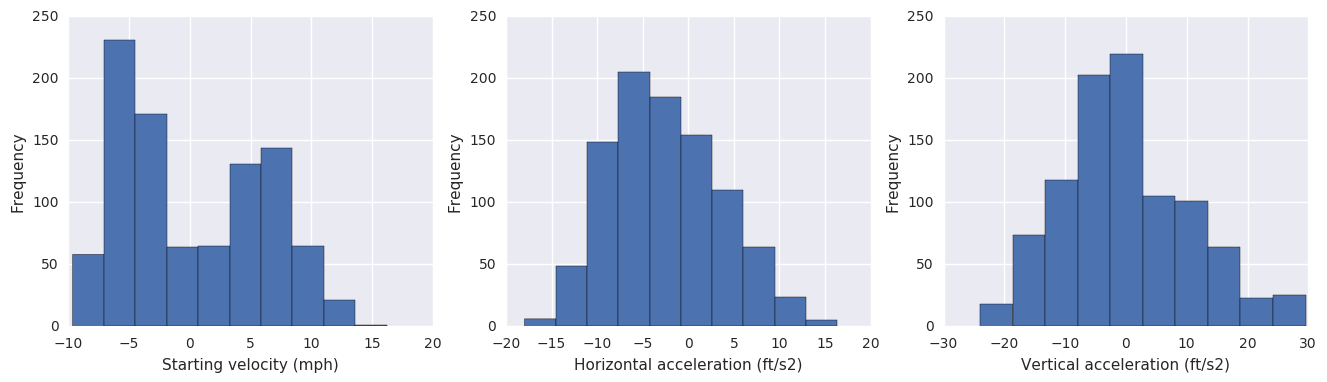

In [35]:
# histograms
diff_test = y_pred2-y_test
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
nbins = 10

diff_test['start_speed'].plot.hist(bins=nbins, ax=ax[0])
ax[0].set_xlabel("Starting velocity (mph)")

diff_test['ax'].plot.hist(bins=nbins, ax=ax[1])
ax[1].set_xlabel("Horizontal acceleration (ft/s2)")

diff_test['az'].plot.hist(bins=nbins, ax=ax[2])
ax[2].set_xlabel("Vertical acceleration (ft/s2)")

plt.show()